In [28]:
import pandas as pd
import openai
from sklearn.preprocessing import LabelEncoder                                              

In [29]:
grammer_data = pd.read_csv("./grammer_data.csv", header=1)

In [30]:
grammer_data.head()

,대분류,소분류,난이도,문장,해석
0,문장 형식,주어+완전자동사 (S+V),하,You win.,네가 이겼어.
1,문장 형식,주어+완전자동사 (S+V),하,Going up?,올라가나요?
2,문장 형식,주어+완전자동사 (S+V),하,Let's see.,어디 보자.
3,문장 형식,주어+완전자동사 (S+V),하,Let's try.,한 번 해봅시다.
4,문장 형식,주어+완전자동사 (S+V),하,Speak out.,거리낌 없이 얘기 해.


In [31]:
dataset={}
for category in grammer_data['catetory'].unique():
    dataset[category] = grammer_data[grammer_data['catetory']==category][['catetory','detail','sentence']]
    encoder = LabelEncoder()
    dataset[category]['detail']=encoder.fit_transform(dataset[category]['detail'].values)

In [33]:
display(encoder.inverse_transform(dataset[category]['detail']))

array(['가능 여부 표현하기', '가능 여부 표현하기', '가능 여부 표현하기', ..., '인물묘사하기', '인물묘사하기',
       '인물묘사하기'], dtype=object)

In [34]:
dataset.keys()

dict_keys(['문장 형식', '문장의 종류', '문장 구성 요소', '명사 (nouns)', '대명사 (referents)', '동사 (verbs)', '시제 (tense)', '조동사 (modals)', '형용사 (adjectives)', '부사 (adverbs)', '전치사 (prepositions)', '접속사 (conjunctions)', '한정사 (determiners)', '부정 (negation)', '도치 강조 생략 삽입', '분사 (participle)', '동명사 (gerunds)', '부정사 (infinitives)', '비교 (comparison)', '관계사 (relatives)', '태 (voice)', '가정법 (subjunctives)', '문장 전환 (transformation)', '빈출 관용 구문', '숙어 (Idioms)', '의사소통 (communicatives)'])

In [36]:
import pandas as pd
import re
import json
import glob, os

os.makedirs('./dataset', exist_ok=True)
english_pattern = re.compile(r'\b[a-zA-Z]+\b')
df_dict={}
for idx, key in enumerate(dataset.keys()):
    labels = [i for i in dataset[key]['detail']]
    texts = [i for i in dataset[key]['문장']]
    df_dict[key] = pd.DataFrame(zip(texts, labels), columns = ['prompt','completion']) #[:300]
    en_key= key if english_pattern.findall(key)==[] else english_pattern.findall(key)[0]
    df_json = df_dict[key].to_json(f"dataset/{en_key}.jsonl", orient='records', lines=True)

In [8]:
!pip install --upgrade openai

In [107]:
filename='sentence_type'

In [106]:
!openai tools fine_tunes.prepare_data -f dataset/{filename}.jsonl -q
!mv dataset/{filename}_prepared_train.jsonl train_valid_dataset/{filename}_prepared_train.jsonl
!mv dataset/{filename}_prepared_valid.jsonl train_valid_dataset/{filename}_prepared_valid.jsonl

Analyzing...

- Your file contains 1489 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 5 duplicated prompt-completion sets. These are rows: [175, 294, 353, 354, 437]
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tokenization we 

In [95]:
import jsonlines

l=[]
with jsonlines.open(f"train_valid_dataset/{filename}_prepared_train.jsonl") as f:
    for line in f.iter():
    	l.append(line)

In [96]:
df=pd.DataFrame(l)
n=df['completion'].nunique()

28

In [97]:
!openai api fine_tunes.create -t "train_valid_dataset/{filename}_prepared_train.jsonl" -v "train_valid_dataset/{filename}_prepared_valid.jsonl" --compute_classification_metrics --classification_n_classes {n}  -m ada

Upload progress: 100%|████████████████████| 80.8k/80.8k [00:00<00:00, 36.2Mit/s]
Uploaded file from train_valid_dataset/sentence_type_prepared_train.jsonl: file-h99H8iq5ZJJ3hV6bQ6PYdv6h
Upload progress: 100%|████████████████████| 20.7k/20.7k [00:00<00:00, 28.7Mit/s]
Uploaded file from train_valid_dataset/sentence_type_prepared_valid.jsonl: file-kuUG53DTJqOPDVRwJSiuFo4T
Created fine-tune: ft-AyPgveTDlwkTnWEIYV1HFAGm
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-02-15 00:47:08] Created fine-tune: ft-AyPgveTDlwkTnWEIYV1HFAGm
^C


In [99]:
!openai api fine_tunes.follow -i ft-AyPgveTDlwkTnWEIYV1HFAGm

[2023-02-15 00:47:08] Created fine-tune: ft-AyPgveTDlwkTnWEIYV1HFAGm
^C


In [23]:
if not os.path.exists('./result'):
    os.makedirs('./result')
    print("make result folder done")

In [69]:
!openai api fine_tunes.results -i ft-uXAk6ISjTGbgMTbhzKWUDtsq > result/result_{filename}.csv

In [70]:
results = pd.read_csv(f'result/result_{filename}.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/weighted_f1_score
2471,2472,100512,4944,0.013006,1.0,1.0,NaN,NaN,NaN,0.79288,0.784456


<AxesSubplot:>

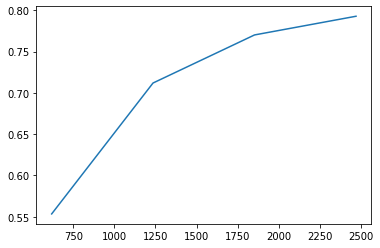

In [71]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

In [85]:
test = pd.read_json('dataset/sentence_type_prepared_valid.jsonl', lines=True)
test[test['completion']==19]

,prompt,completion
143,Save me from being confused. ->,19
144,Put a pad underneath the rug. ->,19
145,Put all your eggs in one basket. ->,19
146,Memories are doing funny things to us. ->,19
147,Keep your broken arm inside your sleeve. ->,19
148,You can't fit a round peg in a square hole. ->,19
149,Cast your cares on God. ->,19
150,She regarded her sister as her best friend. ->,19
151,Cats regard people as warm-blooded furniture. ->,19
152,Pleasure in the job puts perfection in the wor...,19


In [84]:
ft_model = 'ada:ft-personal-2023-02-14-14-23-40'
res = openai.Completion.create(model=ft_model, prompt='We can see that the model predicts hockey as a lot more likely than baseball. ->', max_tokens=1, temperature=0)
res['choices'][0]['text']

' 19'